In [50]:
import numpy as np
import pandas as pd
from tqdm import trange
import matplotlib.pyplot as plt
from collections import defaultdict

In [51]:
ALGORITHMS = ["asp_test_results", "hagen_test_results"]
KB_SIZES = [25, 50, 100, 150]
N_TRIALS = 100

In [52]:
def simulate_time(algo: str, kb_size: int) -> float:
    if algo == "ASP":
        return (2 * kb_size)  ** 2 + 10 + np.random.random() * 100000
    else:
        return kb_size ** 2 + np.random.random() * 50000

In [53]:
rows = []

for algo in ALGORITHMS:
    for kb_size in KB_SIZES:
        filename = f"{algo}/ranked_{kb_size}.txt"
        with open(filename) as file:
            results = file.readlines()
        count = 1
        for trial_idx in results:
            time = trial_idx.replace("\n","")
            rows.append({
                "algorithm": algo,
                "kb_size": kb_size,
                "trial_number": count, 
                "trial_time": float(time)
            })
            count+=1
        

df = pd.DataFrame(rows)

In [54]:
df

,algorithm,kb_size,trial_number,trial_time
0,asp_test_results,25,1,0.007000
1,asp_test_results,25,2,0.003000
2,asp_test_results,25,3,0.003000
3,asp_test_results,25,4,0.003000
4,asp_test_results,25,5,0.003000
...,...,...,...,...
7991,hagen_test_results,150,995,0.076579
7992,hagen_test_results,150,996,0.135091
7993,hagen_test_results,150,997,0.153874
7994,hagen_test_results,150,998,0.125182


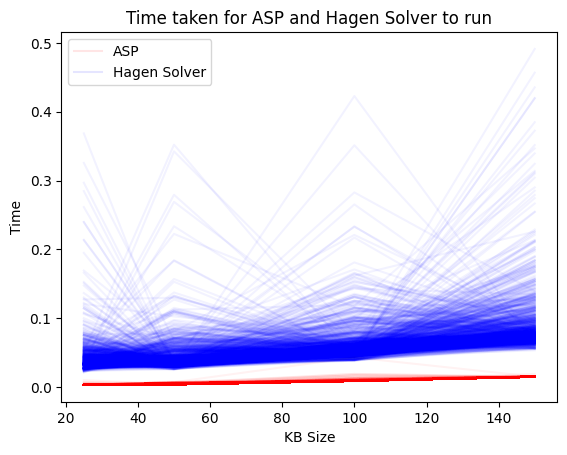

In [58]:
asp_labelled = False
h_thing_labelled = False

for (algo, _), df_t in df.groupby(["algorithm", "trial_number"]):
    colour = 'r' if algo == 'asp_test_results' else 'b'

    if algo == 'asp_test_results':
        if not asp_labelled:
            plt.plot(df_t.kb_size, df_t.trial_time, alpha=0.1, c=colour, label="ASP")
            asp_labelled = True
        else:
            plt.plot(df_t.kb_size, df_t.trial_time, alpha=0.05, c=colour)
    elif algo == 'hagen_test_results':
        if not h_thing_labelled:
            plt.plot(df_t.kb_size, df_t.trial_time, alpha=0.1, c=colour, label="Hagen Solver")
            h_thing_labelled = True
        else:
            plt.plot(df_t.kb_size, df_t.trial_time, alpha=0.05, c=colour)

plt.xlabel("KB Size")
plt.ylabel("Time")
plt.title("Time taken for ASP and Hagen Solver to run")
plt.legend()
plt.show()


In [59]:
def get_bootstrap_ci_for_mean(
    dataset: np.ndarray, n_samples: int = 10000, alpha=0.01
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    bootstrap_estimates = _get_bootstrap_mean_estimates(dataset, n_samples)
    mean = np.mean(dataset, axis=0)
    quatiles = np.quantile(bootstrap_estimates, [alpha, 1 - alpha], axis=0)
    return mean, quatiles[0], quatiles[1]


def _get_bootstrap_mean_estimates(
    dataset: np.ndarray, n_samples: int = 10000
) -> np.ndarray:
    means = []

    for _ in trange(n_samples):
        sample_idx = np.random.choice(
            np.arange(len(dataset)), size=len(dataset), replace=True
        )
        samples = dataset[sample_idx]
        mean_estimate = np.mean(samples, axis=0)
        means.append(mean_estimate)
    return np.array(means)


100%|██████████| 10000/10000 [00:00<00:00, 15870.22it/s]


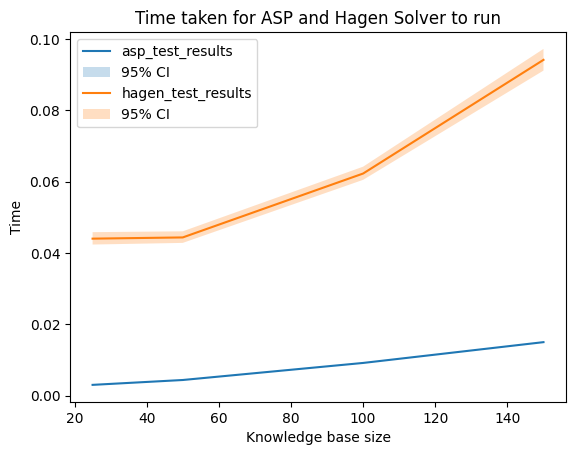

In [60]:
all_trial_times = defaultdict(list)

for (algo, _), df_t in df.groupby(["algorithm", "trial_number"]):
    all_trial_times[algo].append(df_t.trial_time.values)

for algo, trial_times in all_trial_times.items():
    mean, lower, upper = get_bootstrap_ci_for_mean(np.array(trial_times), alpha=0.025)

    plt.plot(KB_SIZES, mean, label=algo)
    plt.fill_between(KB_SIZES, lower, upper, alpha=0.25, label='95% CI')

plt.xlabel("Knowledge base size")
plt.ylabel("Time")
plt.title("Time taken for ASP and Hagen Solver to run")
plt.legend()
plt.show()